<center>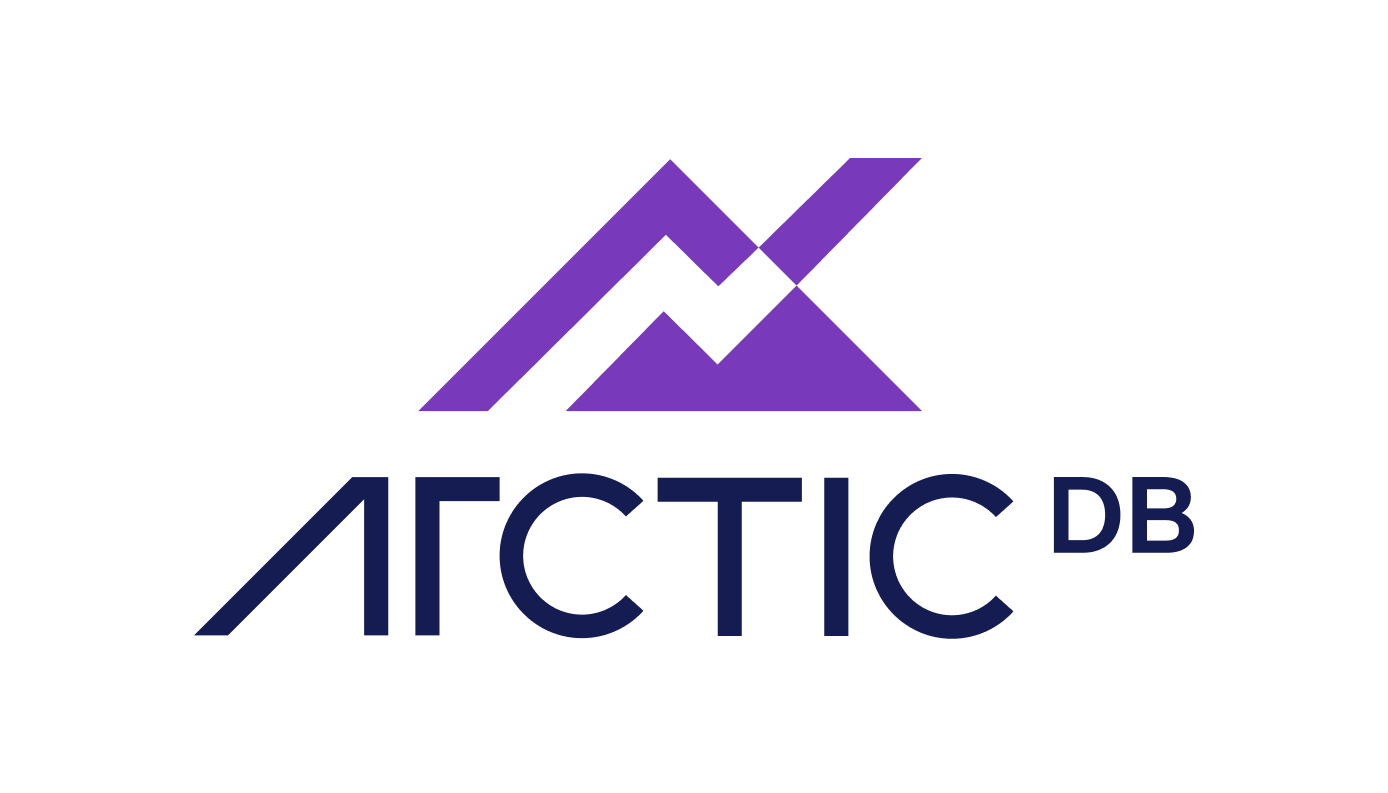
</center>

# ArcticDB SQL — From Basics to Financial Analytics

This notebook demonstrates ArcticDB's DuckDB SQL integration, progressing from
simple queries to real financial analytics.

| Section | Topics |
|---------|--------|
| **1. Setup** | Load real options data + generate synthetic tick data |
| **2. Basics** | SELECT, WHERE, ORDER BY, LIMIT |
| **3. Aggregation** | GROUP BY, SUM, AVG, COUNT |
| **4. OHLC Bars** | Resample tick data to candlestick bars |
| **5. VWAP** | Volume-weighted average price |
| **6. Options Greeks** | Implied volatility surface, Greeks by strike |
| **7. Window Functions** | Running totals, LAG/LEAD, ranking |
| **8. CTEs** | Multi-step analytics with WITH clauses |
| **9. JOINs** | Cross-symbol queries |
| **10. QueryBuilder vs SQL** | Side-by-side comparison of equivalent operations |

In [1]:
!pip install arcticdb duckdb

---
## 1. Setup

We load **real AAPL options data** from the CSV files in `data/` and generate
**synthetic tick-level market data** for time-series analytics.

In [1]:
import numpy as np
import pandas as pd
import arcticdb as adb
from arcticdb.version_store.processing import QueryBuilder
from pathlib import Path

# ArcticDB connection — LMDB for local demo
arctic = adb.Arctic("lmdb://arcticdb_sql_demo")
lib = arctic.get_library("demo", create_if_missing=True)

print(f"ArcticDB version: {adb.__version__}")
print(f"Pandas version:   {pd.__version__}")

ArcticDB version: dev
Pandas version:   2.1.4


In [2]:
# --- Load real AAPL options data from CSV ---
DATA_DIR = Path("data")

options_frames = []
for csv_file in sorted(DATA_DIR.glob("*tech-options.csv")):
    df = pd.read_csv(csv_file, index_col=0)
    options_frames.append(df)
    print(f"Loaded {csv_file.name}: {len(df):,} rows")

options = pd.concat(options_frames, ignore_index=True)

# Clean up types
options["expiration"] = pd.to_datetime(options["expiration"])
options["quote_date"] = pd.to_datetime(options["quote_date"])
for col in ["bid", "ask", "strike", "delta", "gamma", "theta", "vega", "implied_volatility"]:
    options[col] = pd.to_numeric(options[col], errors="coerce")
for col in ["volume", "open_interest"]:
    options[col] = pd.to_numeric(options[col], errors="coerce").fillna(0).astype(np.int64)

# Use quote_date as the index for ArcticDB date range queries
options = options.set_index("quote_date").sort_index()

lib.write("options", options)
print(f"\nWritten 'options': {len(options):,} rows, {len(options.columns)} columns")
options.head(3)

Loaded 2013-06-03tech-options.csv: 6,792 rows
Loaded 2013-06-10tech-options.csv: 6,622 rows
Loaded 2013-06-17tech-options.csv: 6,442 rows
Loaded 2013-06-24tech-options.csv: 6,134 rows

Written 'options': 25,990 rows, 17 columns


,contract,underlying,expiration,type,strike,style,bid,bid_size,ask,ask_size,volume,open_interest,delta,gamma,theta,vega,implied_volatility
quote_date,,,,,,,,,,,,,,,,,
2013-06-03,AAPL130607C00330000,AAPL,2013-06-07,call,330.0,A,118.55,NaN,121.10,NaN,0,0,1.0,0.0,-0.9032,0.0,0.3333
2013-06-03,AAPL130607P00330000,AAPL,2013-06-07,put,330.0,A,0.00,NaN,0.01,NaN,0,325,0.0,0.0,0.0000,0.0,0.3817
2013-06-03,AAPL130607C00340000,AAPL,2013-06-07,call,340.0,A,108.60,NaN,111.10,NaN,0,0,1.0,0.0,-0.9306,0.0,0.3333


In [11]:
# --- Generate synthetic tick-level market data ---
# 1-second ticks for 5 trading days, 6.5 hours per day
rng = np.random.default_rng(42)
n_days = 365 * 20
seconds_per_day = 6 * 3600 + 30 * 60  # 6.5 hours
n_ticks = n_days * seconds_per_day

dates = []
for d in pd.bdate_range("2024-01-02", periods=n_days):
    market_open = d + pd.Timedelta(hours=9, minutes=30)
    dates.extend(pd.date_range(market_open, periods=seconds_per_day, freq="s"))

# Simulate price as a random walk around $150
returns = rng.normal(0, 0.0002, n_ticks)
price = 150.0 * np.exp(np.cumsum(returns))

# Volume: higher at open/close, lower midday
hour_of_day = np.array([(t.hour + t.minute / 60) for t in dates])
volume_shape = np.where(hour_of_day < 10.5, 3.0, np.where(hour_of_day > 15.0, 2.5, 1.0))
volume = (rng.exponential(500, n_ticks) * volume_shape).astype(np.int64) + 1

ticks = pd.DataFrame({
    "price": np.round(price, 2),
    "volume": volume,
    "side": rng.choice(["buy", "sell"], n_ticks),
}, index=pd.DatetimeIndex(dates, name="timestamp"))

lib.write("ticks", ticks)
print(f"Written 'ticks': {len(ticks):,} rows")
ticks.head(3)

Written 'ticks': 170,820,000 rows


,price,volume,side
timestamp,,,
2024-01-02 09:30:00,150.01,2599,sell
2024-01-02 09:30:01,149.98,2761,sell
2024-01-02 09:30:02,150.00,2841,sell


In [ ]:
# --- Generate trade-level data for multiple tickers ---
tickers = ["AAPL", "MSFT", "GOOG", "AMZN", "NVDA"]
n_trades = 50_000_000

trade_dates = pd.date_range("2024-01-02", periods=n_trades, freq="12s")

trades = pd.DataFrame({
    "ticker": rng.choice(tickers, n_trades),
    "price": np.round(rng.uniform(100, 500, n_trades), 2),
    "quantity": rng.integers(1, 1000, n_trades),
    "side": rng.choice(["buy", "sell"], n_trades),
    "notional_usd": np.round(rng.uniform(1000, 500_000, n_trades), 2),
    "slippage_bps": np.round(rng.normal(0, 5, n_trades), 2),
}, index=trade_dates)
trades.index.name = "timestamp"

lib.write("trades", trades)
print(f"Written 'trades': {len(trades):,} rows")

# Reference data for JOINs
ref = pd.DataFrame({
    "ticker": tickers,
    "name": ["Apple", "Microsoft", "Alphabet", "Amazon", "NVIDIA"],
    "sector": ["Tech", "Tech", "Tech", "Consumer", "Semiconductors"],
    "market_cap_bn": [3000, 2800, 1800, 1900, 2500],
}, index=pd.RangeIndex(len(tickers)))

lib.write("reference", ref)
print(f"Written 'reference': {len(ref)} rows")

print(f"\nAll symbols: {lib.list_symbols()}")

---
## 2. SQL Basics — SELECT, WHERE, ORDER BY, LIMIT

Use `lib.sql()` to query any symbol as if it were a SQL table.
ArcticDB automatically pushes down column selections and WHERE filters to the storage engine.

In [5]:
# Simple SELECT with column projection
lib.sql("SELECT contract, strike, type, bid, ask FROM options LIMIT 10")

,contract,strike,type,bid,ask
0,AAPL130607C00330000,330.0,call,118.55,121.10
1,AAPL130607P00330000,330.0,put,0.00,0.01
2,AAPL130607C00340000,340.0,call,108.60,111.10
3,AAPL130607P00340000,340.0,put,0.00,0.01
4,AAPL130607C00350000,350.0,call,99.85,101.10
5,AAPL130607P00350000,350.0,put,0.00,0.01
6,AAPL130607C00355000,355.0,call,93.60,96.10
7,AAPL130607P00355000,355.0,put,0.00,0.01
8,AAPL130607C00360000,360.0,call,89.50,91.10
9,AAPL130607P00360000,360.0,put,0.00,0.03


In [6]:
# WHERE filter — pushed down to ArcticDB storage engine
lib.sql("""
    SELECT contract, strike, type, bid, ask, volume
    FROM options
    WHERE type = 'call'
      AND strike BETWEEN 400 AND 500
      AND volume > 100
    ORDER BY volume DESC
    LIMIT 15
""")

,contract,strike,type,bid,ask,volume
0,AAPL130614C00450000,450.0,call,1.44,1.50,32676
1,AAPL130607C00450000,450.0,call,5.50,5.60,26396
2,AAPL130720C00470000,470.0,call,2.00,2.02,25174
3,AAPL130614C00460000,460.0,call,0.35,0.39,24077
4,AAPL130614C00455000,455.0,call,0.71,0.75,22273
5,AAPL130622C00440000,440.0,call,1.35,1.38,20767
6,AAPL130607C00455000,455.0,call,3.25,3.35,20738
7,AAPL130614C00445000,445.0,call,2.74,2.80,20724
8,AAPL130607C00460000,460.0,call,1.79,1.85,19878
9,AAPL130622C00435000,435.0,call,2.85,2.96,18706


In [7]:
# See what gets pushed down to storage
lib.explain("""
    SELECT contract, strike, bid, ask
    FROM options
    WHERE type = 'call' AND strike > 450
    LIMIT 100
""")

{'query': "\n    SELECT contract, strike, bid, ask\n    FROM options\n    WHERE type = 'call' AND strike > 450\n    LIMIT 100\n",
 'symbols': ['options'],
 'columns_pushed_down': ['contract', 'strike', 'type', 'ask', 'bid'],
 'filter_pushed_down': True,
 'limit_pushed_down': 100}

---
## 3. Aggregation — GROUP BY, SUM, AVG, COUNT

SQL aggregations run in DuckDB after ArcticDB streams the (filtered) data.

In [9]:
# Volume and open interest by option type
lib.sql("""
    SELECT
        type,
        COUNT(*) AS num_contracts,
        SUM(volume) AS total_volume,
        SUM(open_interest) AS total_oi,
        ROUND(AVG(implied_volatility), 4) AS avg_iv
    FROM options
    GROUP BY type
""")

,type,num_contracts,total_volume,total_oi,avg_iv
0,put,12995,1304579,16531727,0.3694
1,call,12995,2034997,23399075,0.3756


In [8]:
# Trade statistics by ticker
lib.sql("""
    SELECT
        ticker,
        COUNT(*) AS num_trades,
        SUM(quantity) AS total_shares,
        ROUND(SUM(notional_usd), 2) AS total_notional,
        ROUND(AVG(price), 2) AS avg_price,
        ROUND(AVG(slippage_bps), 2) AS avg_slippage_bps
    FROM trades
    GROUP BY ticker
    ORDER BY total_notional DESC
""")

,ticker,num_trades,total_shares,total_notional,avg_price,avg_slippage_bps
0,MSFT,10130,5068723,2.510861e+09,298.26,0.03
1,AAPL,10034,5011852,2.507316e+09,299.99,-0.03
2,NVDA,10062,5046098,2.505170e+09,298.33,-0.05
3,AMZN,9880,4927892,2.477490e+09,299.11,0.03
4,GOOG,9894,4935806,2.441579e+09,301.74,-0.03


---
## 4. OHLC Bars — Resample Tick Data to Candlesticks

A classic time-series operation: downsample second-level ticks into
Open-High-Low-Close bars using `DATE_TRUNC` in SQL.

In [9]:
# 5-minute OHLC bars via SQL
ohlc_sql = lib.sql("""
    SELECT
        TIME_BUCKET(INTERVAL '5 minutes', "timestamp") AS bar,
        FIRST(price) AS open,
        MAX(price) AS high,
        MIN(price) AS low,
        LAST(price) AS close,
        SUM(volume) AS volume
    FROM ticks
    GROUP BY bar
    ORDER BY bar
""")

print(f"Ticks: {len(ticks):,} rows → OHLC bars: {len(ohlc_sql):,} rows")
ohlc_sql.head(10)

Ticks: 117,000 rows → OHLC bars: 390 rows


,bar,open,high,low,close,volume
0,2024-01-02 09:30:00,150.01,150.16,149.53,149.63,475764
1,2024-01-02 09:35:00,149.68,150.12,149.53,149.53,456156
2,2024-01-02 09:40:00,149.55,149.58,148.82,148.82,525132
3,2024-01-02 09:45:00,148.83,149.43,148.82,149.20,432982
4,2024-01-02 09:50:00,149.16,149.35,148.70,149.08,436337
5,2024-01-02 09:55:00,149.06,149.14,147.78,147.78,416548
6,2024-01-02 10:00:00,147.78,147.81,146.53,146.64,419641
7,2024-01-02 10:05:00,146.64,147.26,146.46,146.97,461502
8,2024-01-02 10:10:00,146.95,147.54,146.54,147.29,457308
9,2024-01-02 10:15:00,147.32,147.73,147.14,147.72,421019


---
## 5. VWAP — Volume-Weighted Average Price

`VWAP = SUM(price × volume) / SUM(volume)`

Calculated per time bucket, this is a standard intraday benchmark.

In [10]:
# Hourly VWAP via SQL
lib.sql("""
    SELECT
        TIME_BUCKET(INTERVAL '1 hour', "timestamp") AS bucket,
        ROUND(SUM(price * volume) / SUM(volume), 4) AS vwap,
        SUM(volume) AS total_volume,
        COUNT(*) AS tick_count
    FROM ticks
    GROUP BY bucket
    ORDER BY bucket
    LIMIT 15
""")

,bucket,vwap,total_volume,tick_count
0,2024-01-02 09:00:00,149.2532,2742919,1800
1,2024-01-02 10:00:00,147.4697,3499577,3600
2,2024-01-02 11:00:00,148.4309,1799145,3600
3,2024-01-02 12:00:00,146.4425,1788136,3600
4,2024-01-02 13:00:00,145.4118,1804543,3600
5,2024-01-02 14:00:00,148.6643,1816892,3600
6,2024-01-02 15:00:00,153.0732,4399296,3600
7,2024-01-03 09:00:00,155.3744,2729841,1800
8,2024-01-03 10:00:00,157.6909,3590274,3600
9,2024-01-03 11:00:00,158.4006,1784808,3600


---
## 6. Options Greeks Analysis

Analyse the real AAPL options data: implied volatility surface,
Greeks distributions, and put-call parity checks.

In [13]:
# Implied volatility by strike bucket for calls vs puts
lib.sql("""
    SELECT
        type,
        ROUND(strike / 10, 0) * 10 AS strike_bucket,
        COUNT(*) AS n,
        ROUND(AVG(implied_volatility), 4) AS avg_iv,
        ROUND(AVG(delta), 4) AS avg_delta,
        ROUND(AVG(gamma), 6) AS avg_gamma
    FROM options
    WHERE implied_volatility > 0
      AND strike BETWEEN 350 AND 500
    GROUP BY type, strike_bucket
    ORDER BY type, strike_bucket
""")

,type,strike_bucket,n,avg_iv,avg_delta,avg_gamma
0,call,350.0,71,0.3213,0.6070,0.001758
1,call,360.0,129,0.3176,0.6139,0.001920
2,call,370.0,132,0.3136,0.6115,0.002120
3,call,380.0,132,0.3093,0.5896,0.002539
4,call,390.0,132,0.3051,0.5622,0.003169
5,call,400.0,126,0.3005,0.5522,0.004088
6,call,410.0,118,0.2953,0.5430,0.005094
7,call,420.0,111,0.2899,0.5205,0.006135
8,call,430.0,98,0.2848,0.5087,0.007806
9,call,440.0,90,0.2811,0.4651,0.008959


In [14]:
# Most liquid options — high volume + tight spread
lib.sql("""
    SELECT
        contract,
        type,
        strike,
        expiration,
        volume,
        open_interest,
        ROUND(ask - bid, 2) AS spread,
        ROUND((ask - bid) / ((ask + bid) / 2) * 100, 2) AS spread_pct,
        ROUND(implied_volatility, 4) AS iv
    FROM options
    WHERE volume > 50
      AND bid > 0
      AND ask > bid
    ORDER BY volume DESC
    LIMIT 20
""")

,contract,type,strike,expiration,volume,open_interest,spread,spread_pct,iv
0,CSCO130720C00026000,call,26.0,2013-07-20,41529,53043,0.02,9.52,0.2224
1,CSCO130622C00025000,call,25.0,2013-06-22,40370,91222,0.01,4.26,0.2192
2,AAPL130614C00450000,call,450.0,2013-06-14,32676,8049,0.06,4.08,0.3103
3,MSFT130720C00032000,call,32.0,2013-07-20,31536,102390,0.10,2.63,0.2659
4,MSFT130720C00035000,call,35.0,2013-07-20,31301,27141,0.02,1.40,0.2215
5,AAPL130607C00450000,call,450.0,2013-06-07,26396,6919,0.10,1.80,0.3009
6,AAPL130720C00470000,call,470.0,2013-07-20,25174,9557,0.02,1.00,0.2451
7,AAPL130614C00460000,call,460.0,2013-06-14,24077,6923,0.04,10.81,0.3197
8,AAPL130628P00400000,put,400.0,2013-06-28,22602,4050,0.15,3.39,0.3666
9,AAPL130614C00455000,call,455.0,2013-06-14,22273,5056,0.04,5.48,0.3118


---
## 7. Window Functions

DuckDB window functions enable running totals, rankings, and
row-to-row comparisons without self-joins.

In [15]:
# Cumulative volume and running VWAP throughout first trading day
lib.sql("""
    SELECT
        "timestamp",
        price,
        volume,
        SUM(volume) OVER (ORDER BY "timestamp") AS cum_volume,
        ROUND(
            SUM(price * volume) OVER (ORDER BY "timestamp")
            / SUM(volume) OVER (ORDER BY "timestamp"),
        4) AS running_vwap
    FROM ticks
    WHERE "timestamp" < '2024-01-03'
    ORDER BY "timestamp"
    LIMIT 20
""")

,timestamp,price,volume,cum_volume,running_vwap
0,2024-01-02 09:30:00,150.01,2685,2685,150.0100
1,2024-01-02 09:30:01,149.98,1572,4257,149.9989
2,2024-01-02 09:30:02,150.00,2909,7166,149.9994
3,2024-01-02 09:30:03,150.03,534,7700,150.0015
4,2024-01-02 09:30:04,149.97,2439,10139,149.9939
5,2024-01-02 09:30:05,149.93,2614,12753,149.9808
6,2024-01-02 09:30:06,149.93,3411,16164,149.9701
7,2024-01-02 09:30:07,149.93,846,17010,149.9681
8,2024-01-02 09:30:08,149.92,983,17993,149.9655
9,2024-01-02 09:30:09,149.90,404,18397,149.9640


In [16]:
# Rank trades by notional within each ticker
lib.sql("""
    SELECT
        ticker,
        price,
        quantity,
        notional_usd,
        RANK() OVER (PARTITION BY ticker ORDER BY notional_usd DESC) AS rank_in_ticker
    FROM trades
    QUALIFY rank_in_ticker <= 3
    ORDER BY ticker, rank_in_ticker
""")

,ticker,price,quantity,notional_usd,rank_in_ticker
0,AAPL,251.14,473,499957.38,1
1,AAPL,420.48,86,499940.41,2
2,AAPL,228.86,573,499936.79,3
3,AMZN,189.13,607,499975.27,1
4,AMZN,475.51,497,499942.32,2
5,AMZN,204.84,27,499914.26,3
6,GOOG,381.89,103,499996.34,1
7,GOOG,203.03,657,499954.16,2
8,GOOG,207.91,978,499942.76,3
9,MSFT,251.69,516,499981.65,1


In [17]:
# Tick-to-tick price change and percentage move
lib.sql("""
    SELECT
        "timestamp",
        price,
        LAG(price) OVER (ORDER BY "timestamp") AS prev_price,
        ROUND(price - LAG(price) OVER (ORDER BY "timestamp"), 2) AS price_change,
        ROUND(
            (price - LAG(price) OVER (ORDER BY "timestamp"))
            / LAG(price) OVER (ORDER BY "timestamp") * 10000,
        2) AS change_bps
    FROM ticks
    WHERE "timestamp" < '2024-01-03'
    ORDER BY "timestamp"
    LIMIT 15
""")

,timestamp,price,prev_price,price_change,change_bps
0,2024-01-02 09:30:00,150.01,NaN,NaN,NaN
1,2024-01-02 09:30:01,149.98,150.01,-0.03,-2.00
2,2024-01-02 09:30:02,150.00,149.98,0.02,1.33
3,2024-01-02 09:30:03,150.03,150.00,0.03,2.00
4,2024-01-02 09:30:04,149.97,150.03,-0.06,-4.00
5,2024-01-02 09:30:05,149.93,149.97,-0.04,-2.67
6,2024-01-02 09:30:06,149.93,149.93,0.00,0.00
7,2024-01-02 09:30:07,149.93,149.93,0.00,0.00
8,2024-01-02 09:30:08,149.92,149.93,-0.01,-0.67
9,2024-01-02 09:30:09,149.90,149.92,-0.02,-1.33


---
## 8. CTEs — Multi-Step Analytics

`WITH` (Common Table Expressions) let you build complex analytics
step by step. ArcticDB's SQL interface supports CTEs natively.

In [18]:
# Slippage analysis: bucket trades by size, compute weighted avg slippage
lib.sql("""
    WITH sized_trades AS (
        SELECT
            ticker,
            CASE
                WHEN notional_usd < 10000 THEN 'Small (<10k)'
                WHEN notional_usd < 100000 THEN 'Medium (10k-100k)'
                ELSE 'Large (>100k)'
            END AS size_bucket,
            notional_usd,
            slippage_bps
        FROM trades
    )
    SELECT
        size_bucket,
        COUNT(*) AS num_trades,
        ROUND(SUM(notional_usd), 0) AS total_notional,
        ROUND(
            SUM(slippage_bps * notional_usd) / SUM(notional_usd),
        2) AS weighted_avg_slippage_bps
    FROM sized_trades
    GROUP BY size_bucket
    ORDER BY total_notional DESC
""")

,size_bucket,num_trades,total_notional,weighted_avg_slippage_bps
0,Large (>100k),39980,1.194134e+10,0.00
1,Medium (10k-100k),9097,4.959954e+08,-0.06
2,Small (<10k),923,5.077553e+06,0.12


In [19]:
# Intraday pattern: hourly volume profile with % of daily total
lib.sql("""
    WITH hourly AS (
        SELECT
            DATE_TRUNC('day', "timestamp") AS trading_day,
            EXTRACT(HOUR FROM "timestamp") AS hour,
            SUM(volume) AS hourly_volume
        FROM ticks
        GROUP BY trading_day, hour
    ),
    daily_totals AS (
        SELECT
            trading_day,
            SUM(hourly_volume) AS daily_volume
        FROM hourly
        GROUP BY trading_day
    )
    SELECT
        h.hour,
        ROUND(AVG(h.hourly_volume), 0) AS avg_hourly_volume,
        ROUND(AVG(h.hourly_volume * 100.0 / d.daily_volume), 1) AS pct_of_daily
    FROM hourly h
    JOIN daily_totals d ON h.trading_day = d.trading_day
    GROUP BY h.hour
    ORDER BY h.hour
""")

,hour,avg_hourly_volume,pct_of_daily
0,9,2699975.0,15.1
1,10,3562175.0,19.9
2,11,1780608.0,10.0
3,12,1793668.0,10.0
4,13,1794999.0,10.0
5,14,1796896.0,10.1
6,15,4438245.0,24.8


---
## 9. JOINs — Cross-Symbol Queries

Use `lib.duckdb()` context manager to register multiple symbols
and query across them.

In [20]:
# JOIN trades with reference data for enriched analytics
with lib.duckdb() as ddb:
    ddb.register_symbol("trades")
    ddb.register_symbol("reference")

    result = ddb.sql("""
        SELECT
            r.name,
            r.sector,
            COUNT(*) AS num_trades,
            ROUND(SUM(t.notional_usd), 0) AS total_notional,
            ROUND(SUM(t.notional_usd) / r.market_cap_bn / 1e7, 2) AS turnover_pct,
            ROUND(
                SUM(t.slippage_bps * t.notional_usd) / SUM(t.notional_usd),
            2) AS weighted_slippage_bps
        FROM trades t
        JOIN reference r ON t.ticker = r.ticker
        GROUP BY r.name, r.sector, r.market_cap_bn
        ORDER BY total_notional DESC
    """)

result

,name,sector,num_trades,total_notional,turnover_pct,weighted_slippage_bps
0,Microsoft,Tech,10130,2.510861e+09,0.09,0.03
1,Apple,Tech,10034,2.507316e+09,0.08,0.01
2,NVIDIA,Semiconductors,10062,2.505170e+09,0.10,-0.02
3,Amazon,Consumer,9880,2.477490e+09,0.13,0.02
4,Alphabet,Tech,9894,2.441579e+09,0.14,-0.05


In [21]:
# Sector-level aggregation using JOIN
with lib.duckdb() as ddb:
    ddb.register_symbol("trades")
    ddb.register_symbol("reference")

    result = ddb.sql("""
        SELECT
            r.sector,
            COUNT(DISTINCT t.ticker) AS num_tickers,
            COUNT(*) AS num_trades,
            ROUND(AVG(t.notional_usd), 2) AS avg_trade_size,
            ROUND(AVG(t.slippage_bps), 2) AS avg_slippage
        FROM trades t
        JOIN reference r ON t.ticker = r.ticker
        GROUP BY r.sector
        ORDER BY num_trades DESC
    """)

result

,sector,num_tickers,num_trades,avg_trade_size,avg_slippage
0,Tech,3,30058,248178.70,-0.01
1,Semiconductors,1,10062,248973.35,-0.05
2,Consumer,1,9880,250758.15,0.03


In [22]:
# JOIN + resample: hourly OHLC bars enriched with trade flow
with lib.duckdb() as ddb:
    ddb.register_symbol("ticks")
    ddb.register_symbol("trades")

    result = ddb.sql("""
        WITH hourly_bars AS (
            SELECT
                TIME_BUCKET(INTERVAL '1 hour', "timestamp") AS bucket,
                FIRST(price) AS open,
                MAX(price)   AS high,
                MIN(price)   AS low,
                LAST(price)  AS close,
                SUM(volume)  AS tick_volume,
                ROUND(SUM(price * volume) / SUM(volume), 4) AS vwap
            FROM ticks
            GROUP BY bucket
        ),
        hourly_flow AS (
            SELECT
                TIME_BUCKET(INTERVAL '1 hour', "timestamp") AS bucket,
                COUNT(*)                                     AS num_trades,
                SUM(CASE WHEN side = 'buy'  THEN quantity ELSE 0 END) AS buy_qty,
                SUM(CASE WHEN side = 'sell' THEN quantity ELSE 0 END) AS sell_qty,
                ROUND(SUM(notional_usd), 0)                 AS total_notional,
                ROUND(AVG(slippage_bps), 2)                 AS avg_slippage
            FROM trades
            WHERE ticker = 'AAPL'
            GROUP BY bucket
        )
        SELECT
            b.bucket,
            b.open, b.high, b.low, b.close,
            b.vwap,
            b.tick_volume,
            f.num_trades,
            f.buy_qty,
            f.sell_qty,
            f.total_notional,
            f.avg_slippage
        FROM hourly_bars b
        JOIN hourly_flow f ON b.bucket = f.bucket
        ORDER BY b.bucket
    """)

result

,bucket,open,high,low,close,vwap,tick_volume,num_trades,buy_qty,sell_qty,total_notional,avg_slippage
0,2024-01-02 09:00:00,150.01,150.16,147.78,147.78,149.2532,2742919.0,52,14842.0,11893.0,12030540.0,1.48
1,2024-01-02 10:00:00,147.78,148.68,146.46,147.49,147.4697,3499577.0,68,19638.0,16754.0,16772530.0,0.54
2,2024-01-02 11:00:00,147.48,149.58,147.16,148.18,148.4309,1799145.0,85,23121.0,18357.0,20263275.0,-0.19
3,2024-01-02 12:00:00,148.18,148.72,144.65,145.20,146.4425,1788136.0,52,13984.0,12570.0,13622785.0,-0.11
4,2024-01-02 13:00:00,145.25,146.31,144.17,145.49,145.4118,1804543.0,62,15951.0,12527.0,17250504.0,-0.31
5,2024-01-02 14:00:00,145.50,151.94,145.46,151.69,148.6643,1816892.0,56,15674.0,17074.0,14387973.0,0.28
6,2024-01-02 15:00:00,151.70,154.19,151.70,154.14,153.0732,4399296.0,65,12560.0,20215.0,16537907.0,0.25
7,2024-01-03 09:00:00,154.13,156.60,153.95,155.77,155.3744,2729841.0,60,18709.0,13989.0,15253121.0,-0.57
8,2024-01-03 10:00:00,155.79,159.79,155.41,157.73,157.6909,3590274.0,56,12979.0,11630.0,14459804.0,-0.67
9,2024-01-03 11:00:00,157.73,159.83,157.01,158.14,158.4006,1784808.0,65,19086.0,14476.0,16765233.0,0.41


---
## Summary

| Feature | `lib.sql()` / `lib.duckdb()` |
|---------|-----------------------------|
| **Filter** | `WHERE col > val` (pushed down to storage) |
| **Aggregate** | `GROUP BY` + `SUM`, `AVG`, `COUNT`, etc. |
| **Resample** | `TIME_BUCKET(INTERVAL '5 min', ts)` |
| **Projection** | `SELECT expr AS alias` |
| **Window functions** | `SUM() OVER (...)`, `LAG()`, `RANK()` |
| **CTEs** | `WITH ... AS (...)` |
| **JOINs** | `JOIN` via `lib.duckdb()` context manager |
| **Pushdown** | Column + filter pushdown to ArcticDB storage engine |
| **Explain** | `lib.sql(query, explain=True)` shows pushdown details |


In [23]:
# Cleanup
arctic.delete_library("demo")
print("Done — library deleted.")

Done — library deleted.
